#  Heart Failure Prediction

### <font color = 'green'>Problem Statement<font>

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.





## Attribute Information
Age: Age of the patient in years   

Sex: Sex of the patient [M: Male, F:Female]      

ChestPainType: [TA: Typical Anigna, ATA: Atypical Anigna, NAP: Non Anigal Pain, ASY: Asymptomatic]   

RestingBP: Resting blood pressure in mmHg     

Cholesterol: Serum Cholesterol in mm/dl           

FastingBS: Fasting blood sugar [1:if FastingBS > 120, 0:Otherwise]   

RestingECG: Resting Electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality, LVH: showing probable or definite left ventricular hypertrophy by Estes' citeria]  

MaxHR: Maximum heart rate acheieved [between 60 and 202]  

ExerciseAnigna: Exercise-induced anigna[Y:Yes, N:No] 

Oldpeak: Numeric value measured in depression

ST_Slope: The slope of the peak xercise ST segment [Up:Upsloping, Flat:Flat, Down: Downsloping]

HeartDisease: [1:Heart disease, 0:Normal]

In [235]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from lazypredict.Supervised import LazyClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import StackingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

In [236]:
#Load in the dataset
heart = pd.read_csv("heart (1).csv")
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


In [237]:
heart.shape

(918, 12)

In [238]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [239]:
cat_columns = heart[["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]]
num_columns = heart[["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]]

In [240]:
for col in cat_columns:
    print(heart[col].unique())

['M' 'F']
['ATA' 'NAP' 'ASY' 'TA']
['Normal' 'ST' 'LVH']
['N' 'Y']
['Up' 'Flat' 'Down']


In [241]:
#statistical summary of the dataset
heart.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.00,53.51,9.43,28.00,47.00,54.00,60.00,77.00
RestingBP,918.00,132.40,18.51,0.00,120.00,130.00,140.00,200.00
Cholesterol,918.00,198.80,109.38,0.00,173.25,223.00,267.00,603.00
FastingBS,918.00,0.23,0.42,0.00,0.00,0.00,0.00,1.00
MaxHR,918.00,136.81,25.46,60.00,120.00,138.00,156.00,202.00
Oldpeak,918.00,0.89,1.07,-2.60,0.00,0.60,1.50,6.20
HeartDisease,918.00,0.55,0.50,0.00,0.00,1.00,1.00,1.00


## <font color = 'green'>Exploratory Data Analysis (EDA)<font>

In [242]:
#check for null values
heart.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There are no missing data in this dataset

#### Univariate Analysis
Observations on a single characteristics or attribute

In [243]:
base_color = sns.color_palette()[4]

##### Age

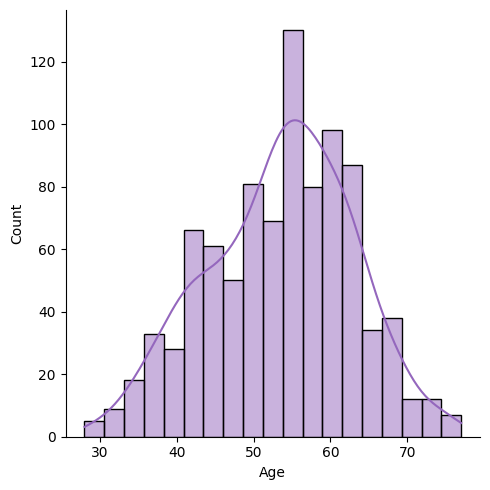

In [244]:
sns.displot(heart.Age, kde=True, color= base_color);

We see that age of individuals in this dataset is slighly skewed to the left with 55 being the peak age

##### Sex

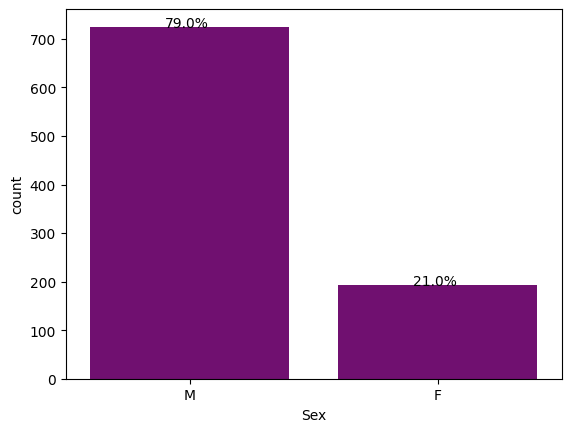

In [245]:
total = heart.shape[0]
ax = sns.countplot(x=heart.Sex, color="purple")
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() - 0.5
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y));

We see 21% of our data is female, so we should expect a bias towards male

##### Chest Pain Type

ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64


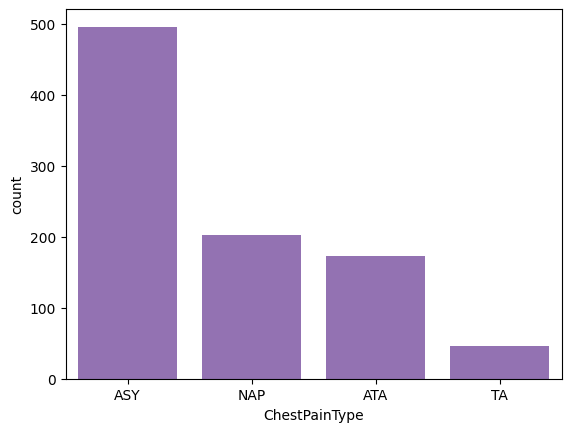

In [246]:
sns.countplot(x=heart.ChestPainType, 
             color=base_color, 
             order=heart.ChestPainType.value_counts().sort_values(ascending=False).index.to_list());
print(heart.ChestPainType.value_counts())

Angina is a type of chest pain caused by reduced blood flow to the heart  

## RestingBP

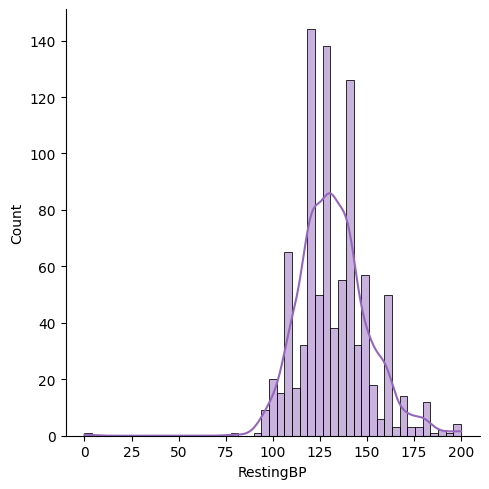

In [247]:
sns.displot(heart.RestingBP, kde=True, color = base_color);

We have some very low values, lower than 75, however the values between 75 and 200 seem to follow a normal distribution. We can further explore for outliers

##### Cholesterol

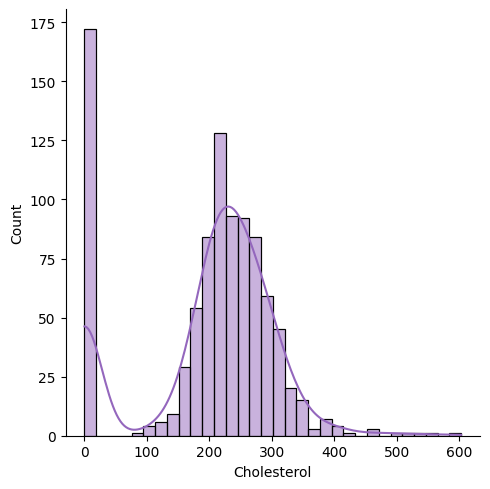

In [248]:
sns.displot(heart.Cholesterol, kde=True, color=base_color);

We see many values with 0 cholesterol which is unusual

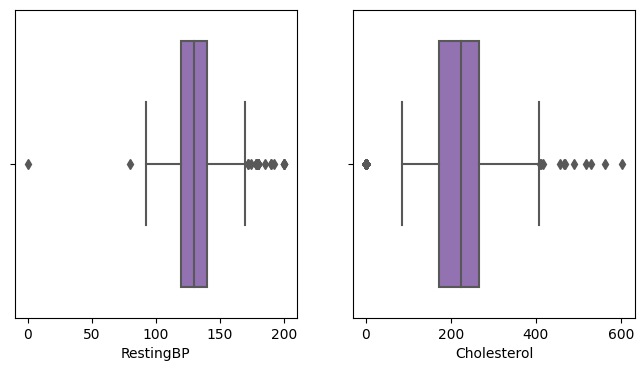

In [249]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
sns.boxplot(x=heart.RestingBP, color=base_color)
plt.ylabel("")

plt.subplot(1,2,2)
sns.boxplot(x=heart.Cholesterol, color=base_color)
plt.ylabel("");


We see 2 outliers with resting bp below 80mmHg, and several with very high resting BPs above 170mmhg                                                         

We see 1 outlier with 0 cholesterol, and several with cholesterol above 400

##### Fasting Blood Sugar

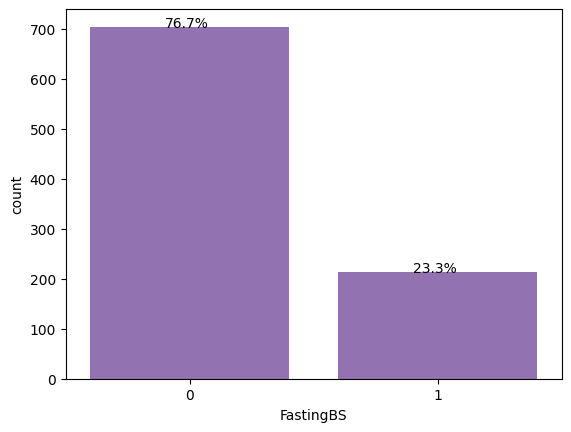

In [250]:
ax=sns.countplot(x=heart.FastingBS, color=base_color)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() - 0.5
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y));

23.3% of individuals had a fasting blood sugar > 120 mg/dl

##### RestingECG

RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64


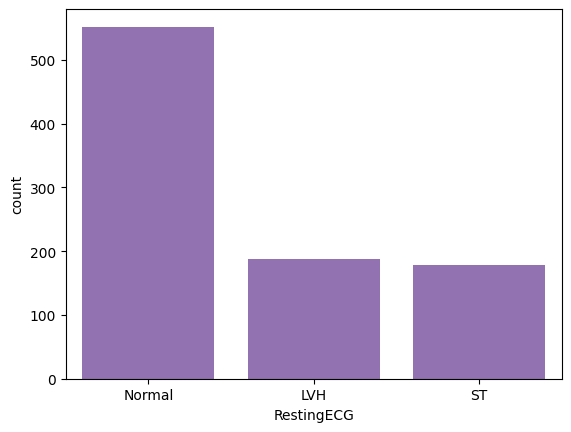

In [251]:
sns.countplot(x=heart.RestingECG, 
             color=base_color, 
             order=heart.RestingECG.value_counts().sort_values(ascending=False).index.to_list());
print(heart.RestingECG.value_counts())

##### Maximum Heart Rate

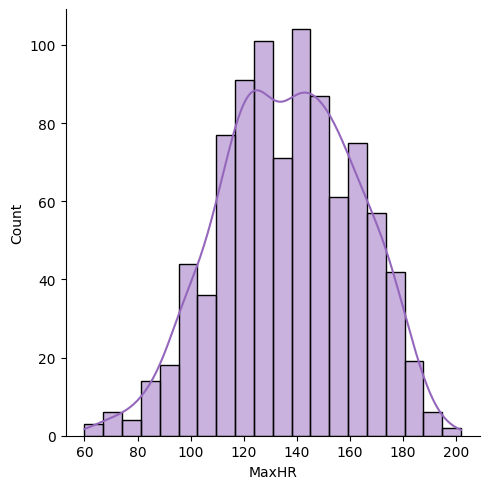

In [252]:
sns.displot(heart.MaxHR, kde=True, color=base_color);

#### ExerciseAnigna

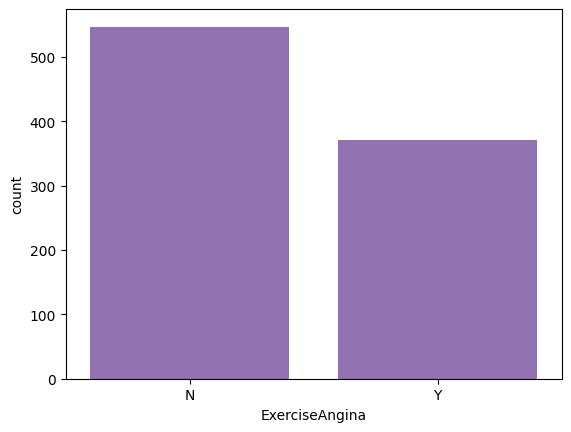

In [253]:
sns.countplot(x=heart["ExerciseAngina"], color= base_color);

In [254]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


##### Old Peak

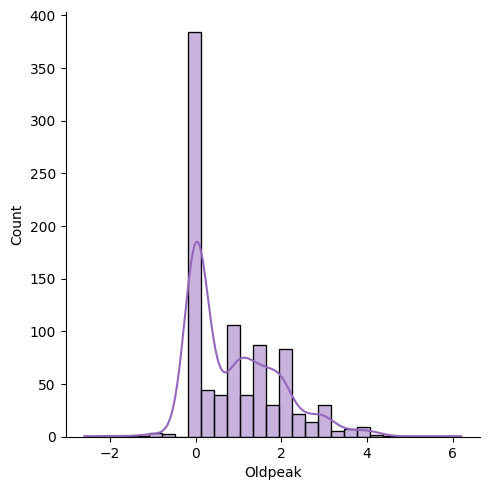

In [255]:
sns.displot(heart.Oldpeak, kde=True, color=base_color);

##### ST Slope

ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64


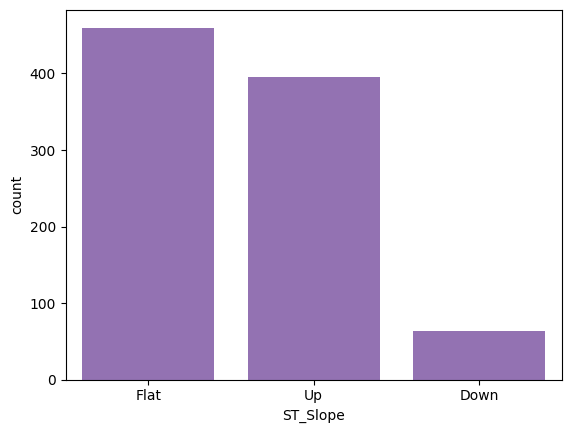

In [256]:
sns.countplot(x=heart.ST_Slope, color=base_color,
               order=heart.ST_Slope.value_counts(ascending=False).index.to_list());
print(heart.ST_Slope.value_counts())

##### Heart Disease

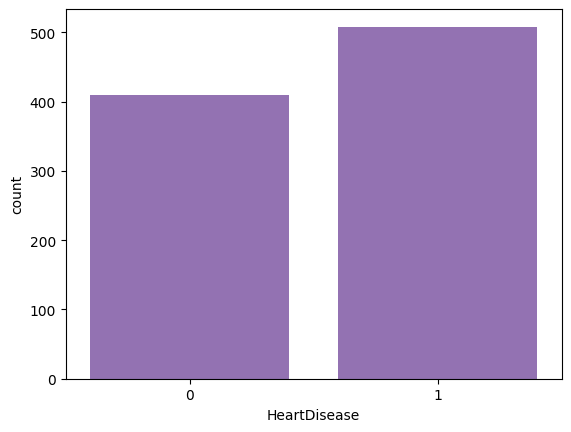

In [257]:
sns.countplot(x=heart.HeartDisease, color=base_color);

## Bivariate Analysis

In [258]:
heart.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

##### Correlation

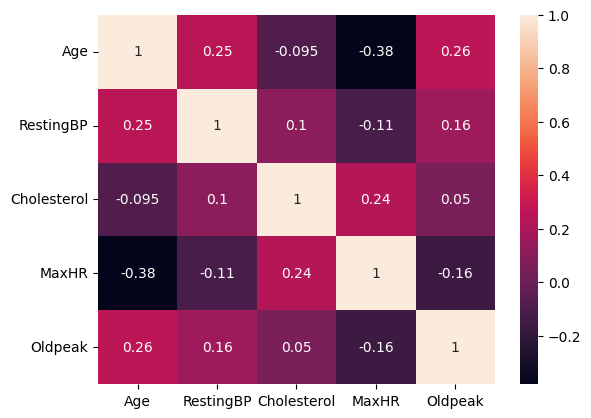

In [259]:
sns.heatmap(num_columns.corr(), annot=True);

In [260]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


We notice very little correlation among the variables

##### Age and Heart Disease

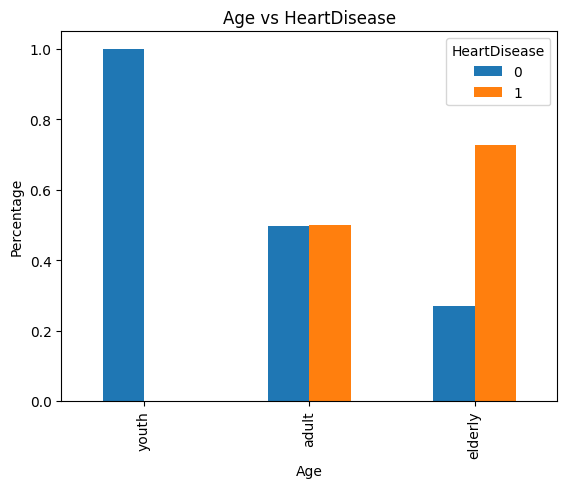

In [261]:
bins = [0, 30, 60, 100]
groups = ["youth", "adult", "elderly"]
heart["age_bin"] = pd.cut(heart["Age"], bins, labels=groups)
age_bin = pd.crosstab(heart["age_bin"], heart["HeartDisease"])
age_bin.div(age_bin.sum(1).astype(float), axis=0).plot(kind="bar")
plt.xlabel("Age")
plt.ylabel("Percentage")
plt.title("Age vs HeartDisease");


From the plot, we notice there are no youth with heart disease, adult between the age 30-60 years have heart disease while elderly people above 60 years are mostly with heart disease.

#### Sex and HeartDisease

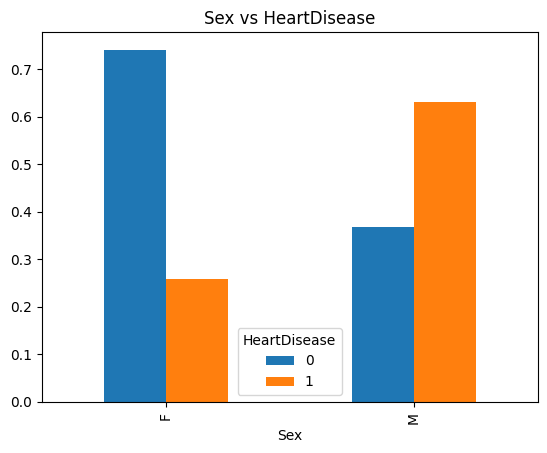

In [262]:
sex = pd.crosstab(heart["Sex"], heart["HeartDisease"])
sex.div(sex.sum(1).astype(float), axis=0).plot(kind="bar")
plt.title("Sex vs HeartDisease");


### ChestPainType and HeartDisease

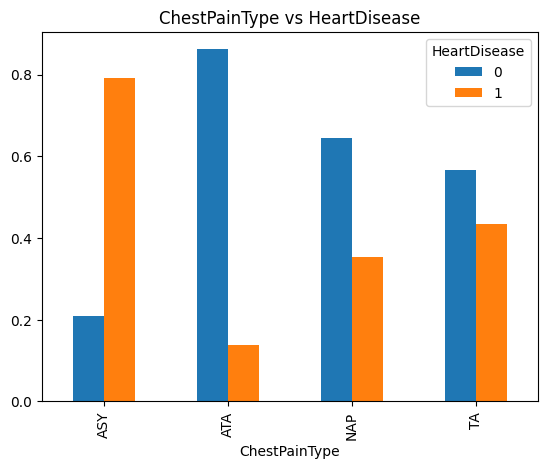

In [263]:
Chest_pain_type = pd.crosstab(heart["ChestPainType"], heart["HeartDisease"])
Chest_pain_type.div(Chest_pain_type.sum(1).astype(float), axis=0).plot(kind="bar")
plt.title("ChestPainType vs HeartDisease");

We see that most people with heart disease were asymptomatic.                     
Generally, most people were asymptomatic, and a higher proportion of asymptomatic patients had heart disease, very few people had atypical angina.

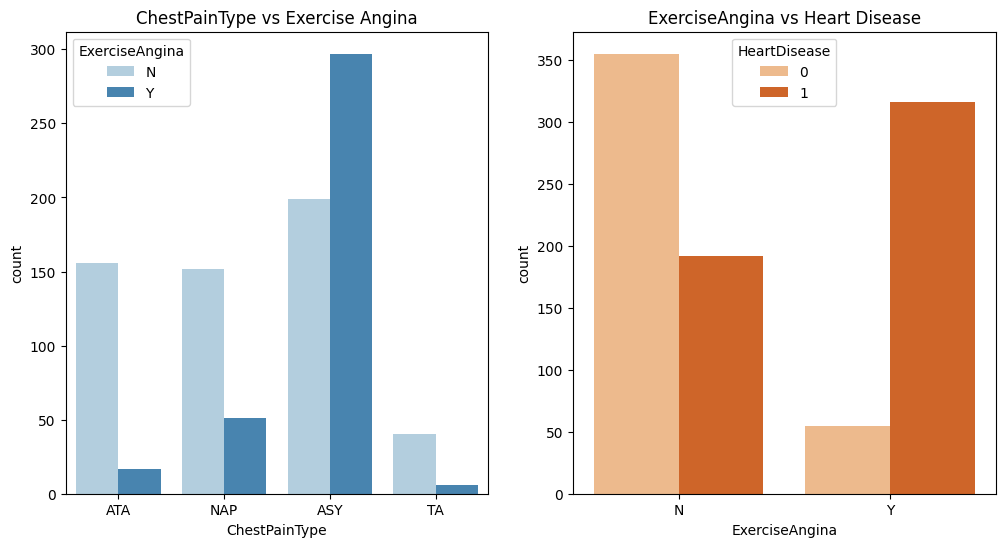

In [264]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.countplot(data=heart, x= "ChestPainType", hue="ExerciseAngina", palette="Blues")
plt.title("ChestPainType vs Exercise Angina");


plt.subplot(1,2,2)
sns.countplot(data=heart, x= "ExerciseAngina", hue="HeartDisease", palette="Oranges")
plt.title("ExerciseAngina vs Heart Disease");

Also, a higher proportion of those that were asymptomatic had exercise induced angina. A small proportion of those without heart disease had exercise induced angina.

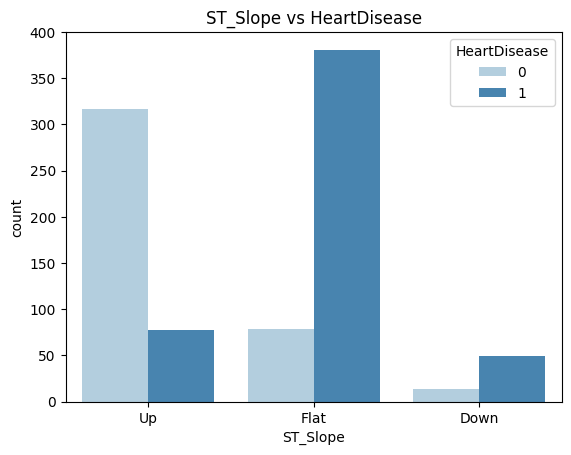

In [265]:
sns.countplot(data=heart, hue= "HeartDisease", x="ST_Slope", palette="Blues")
plt.title("ST_Slope vs HeartDisease");

A large proportion of patients with heart disease had Flat ST Slope, and Up slope was most common among those without heart disease

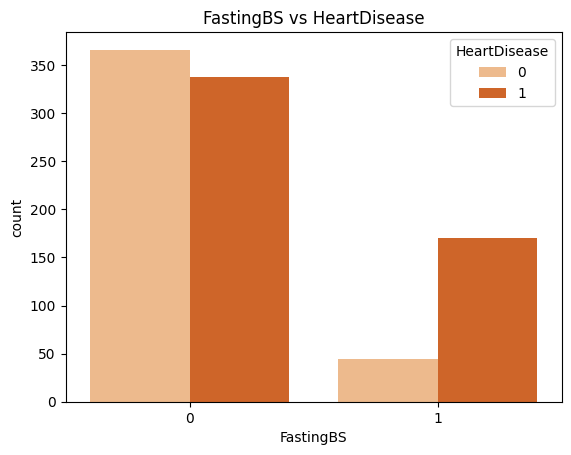

In [266]:
sns.countplot(data=heart, x= "FastingBS", hue="HeartDisease", palette="Oranges")
plt.title("FastingBS vs HeartDisease");

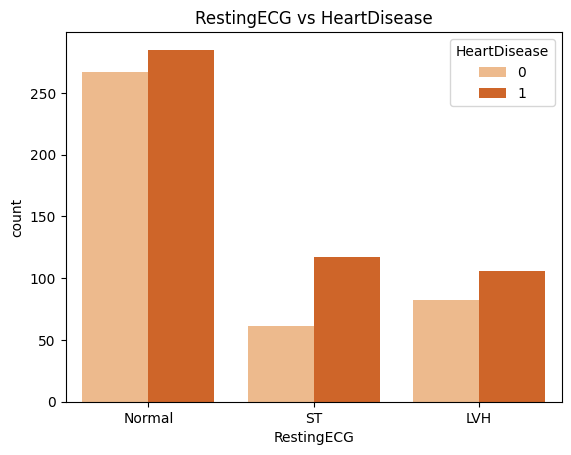

In [267]:
sns.countplot(data=heart, x= "RestingECG", hue="HeartDisease", palette="Oranges")
plt.title("RestingECG vs HeartDisease");

#### Data Preprocessing

In [268]:
col_to_encode = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

label_encoder = LabelEncoder()
for col in col_to_encode:
    heart[col] = label_encoder.fit_transform(heart[col])


In [269]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,age_bin
0,40,1,1,140,289,0,1,172,0,0.00,2,0,adult
1,49,0,2,160,180,0,1,156,0,1.00,1,1,adult
2,37,1,1,130,283,0,2,98,0,0.00,2,0,adult
3,48,0,0,138,214,0,1,108,1,1.50,1,1,adult
4,54,1,2,150,195,0,1,122,0,0.00,2,0,adult


In [270]:
X = heart.drop(columns=["HeartDisease", "age_bin"])
X.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,1,1,140,289,0,1,172,0,0.00,2
1,49,0,2,160,180,0,1,156,0,1.00,1
2,37,1,1,130,283,0,2,98,0,0.00,2
3,48,0,0,138,214,0,1,108,1,1.50,1
4,54,1,2,150,195,0,1,122,0,0.00,2


In [271]:
y = heart["HeartDisease"]
y.head()

0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64

### Feature Selection

In [272]:
selector = SelectKBest(mutual_info_classif, k=7)
x_new = selector.fit_transform(X, y)

In [273]:
selected_features = selector.get_support(indices=True)
feature_names = X.columns[selected_features]
print(feature_names)

Index(['Sex', 'ChestPainType', 'Cholesterol', 'MaxHR', 'ExerciseAngina',
       'Oldpeak', 'ST_Slope'],
      dtype='object')


In [274]:
f_scores, p_values = f_classif(X, y)
f_scores_df = pd.DataFrame({"Feature_Name": X.columns, "f_score": f_scores, "p_valies": p_values})
f_scores_df.sort_values(by="f_score", ascending=False, inplace=True)
print(f_scores_df)

      Feature_Name  f_score  p_valies
10        ST_Slope   415.83      0.00
8   ExerciseAngina   296.14      0.00
9          Oldpeak   178.62      0.00
7            MaxHR   174.91      0.00
2    ChestPainType   161.19      0.00
1              Sex    94.25      0.00
0              Age    79.16      0.00
5        FastingBS    70.48      0.00
4      Cholesterol    52.46      0.00
3        RestingBP    10.73      0.00
6       RestingECG     3.03      0.08


In [275]:
p_values_df = pd.Series(p_values, index = X.columns)
p_values_df.sort_values(ascending=False, inplace=True)
print(p_values_df)

RestingECG       0.08
RestingBP        0.00
Cholesterol      0.00
FastingBS        0.00
Age              0.00
Sex              0.00
ChestPainType    0.00
MaxHR            0.00
Oldpeak          0.00
ExerciseAngina   0.00
ST_Slope         0.00
dtype: float64


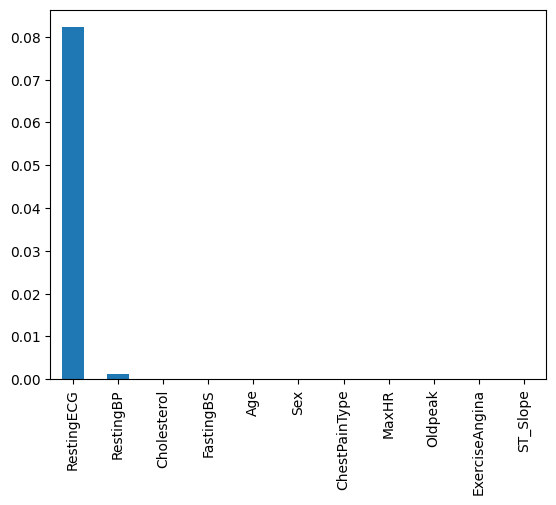

In [276]:
p_values_df.plot.bar();

In [277]:
X.drop(columns=["RestingECG"], axis=1, inplace=True)
X.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,1,1,140,289,0,172,0,0.00,2
1,49,0,2,160,180,0,156,0,1.00,1
2,37,1,1,130,283,0,98,0,0.00,2
3,48,0,0,138,214,0,108,1,1.50,1
4,54,1,2,150,195,0,122,0,0.00,2


#### Checking for Multicollinearity Using Variance Inflation Factor (VIF)
VIF = 1: There is no correlation between a given predictor variable and any other predictor variables in the model      
VIF  between 1 and 5: There is moderate correlation between a given predictor variable and other predictor variables in the model
VIF > 5: There is severe correlation between a given predictor variable and other predictor variables in the model

In [278]:
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns

In [279]:
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [280]:
vif_df.sort_values(by="VIF", ascending=False)

,feature,VIF
3,RestingBP,45.63
0,Age,30.18
6,MaxHR,26.14
9,ST_Slope,9.29
4,Cholesterol,5.12
1,Sex,4.89
8,Oldpeak,2.54
7,ExerciseAngina,2.51
2,ChestPainType,1.99
5,FastingBS,1.48


In [281]:
X.drop(columns=["RestingBP"], axis=1, inplace=True)
X.head()

,Age,Sex,ChestPainType,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,1,1,289,0,172,0,0.00,2
1,49,0,2,180,0,156,0,1.00,1
2,37,1,1,283,0,98,0,0.00,2
3,48,0,0,214,0,108,1,1.50,1
4,54,1,2,195,0,122,0,0.00,2


In [282]:
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns

In [283]:
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [284]:
vif_df.sort_values(by="VIF", ascending=False)

,feature,VIF
5,MaxHR,22.20
0,Age,18.35
8,ST_Slope,9.04
3,Cholesterol,5.00
1,Sex,4.81
7,Oldpeak,2.53
6,ExerciseAngina,2.42
2,ChestPainType,1.99
4,FastingBS,1.47


In [285]:
X.drop(columns=["MaxHR"], axis=1, inplace=True)
X.head()

,Age,Sex,ChestPainType,Cholesterol,FastingBS,ExerciseAngina,Oldpeak,ST_Slope
0,40,1,1,289,0,0,0.00,2
1,49,0,2,180,0,0,1.00,1
2,37,1,1,283,0,0,0.00,2
3,48,0,0,214,0,1,1.50,1
4,54,1,2,195,0,0,0.00,2


In [286]:
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns

In [287]:
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [288]:
vif_df.sort_values(by="VIF", ascending=False)

,feature,VIF
0,Age,14.48
7,ST_Slope,6.92
1,Sex,4.67
3,Cholesterol,4.46
6,Oldpeak,2.48
5,ExerciseAngina,2.41
2,ChestPainType,1.90
4,FastingBS,1.47


In [289]:
X.drop(columns=["Age"], axis=1, inplace=True)
X.head()

,Sex,ChestPainType,Cholesterol,FastingBS,ExerciseAngina,Oldpeak,ST_Slope
0,1,1,289,0,0,0.00,2
1,0,2,180,0,0,1.00,1
2,1,1,283,0,0,0.00,2
3,0,0,214,0,1,1.50,1
4,1,2,195,0,0,0.00,2


In [290]:
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns

In [291]:
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [292]:
vif_df.sort_values(by="VIF", ascending=False)

,feature,VIF
6,ST_Slope,4.86
2,Cholesterol,4.06
0,Sex,4.00
4,ExerciseAngina,2.21
5,Oldpeak,2.17
1,ChestPainType,1.83
3,FastingBS,1.33


In [293]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [294]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


In [295]:
# joblib.dump(scaler, "scaler.pkl")

In [296]:
print('X_train is:', X_train.shape)
print('y_train is :', y_train.shape)

X_train is: (734, 7)
y_train is : (734,)


In [297]:
print('X_test is:', X_test.shape)
print('y_test is :', y_test.shape)

X_test is: (184, 7)
y_test is : (184,)


#### Use a LazyClassifier to Glance the High Performing Models

In [298]:
classifier = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, predictions=True)
models, predictions = classifier.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:02<00:00, 10.38it/s]

[LightGBM] [Info] Number of positive: 406, number of negative: 328
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553134 -> initscore=0.213340
[LightGBM] [Info] Start training from score 0.213340
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [299]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.89,0.89,0.89,0.89,0.38
NuSVC,0.89,0.88,0.88,0.89,0.08
GaussianNB,0.89,0.88,0.88,0.89,0.03
RidgeClassifierCV,0.88,0.88,0.88,0.88,0.03
RidgeClassifier,0.88,0.88,0.88,0.88,0.04
LinearDiscriminantAnalysis,0.88,0.88,0.88,0.88,0.03
SVC,0.88,0.87,0.87,0.88,0.07
BernoulliNB,0.88,0.87,0.87,0.88,0.04
LinearSVC,0.87,0.86,0.86,0.87,0.05


#### AdaBoostClassifier Model

In [300]:
AccuracyScore = []
f1score =[]
RecallScore = []
PrecisionScore = []

params = {
    "n_estimators": 500,
    "learning_rate": 0.1,
    "random_state": 42
}

fold = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model_ada = AdaBoostClassifier(**params)
    model_ada.fit(X_train,y_train)
    pred_ada = model_ada.predict(X_test)
    acc_score= accuracy_score(y_test, pred_ada)
    f1= f1_score(y_test, pred_ada)
    recall= recall_score(y_test, pred_ada)
    precision= precision_score(y_test, pred_ada)
    
AccuracyScore.append(acc_score)
f1score.append(f1)
RecallScore.append(recall)
PrecisionScore.append(precision)

print("Accuracy Score is: ", np.mean(AccuracyScore))
print("F1 Score is: ", np.mean(f1score))
print("Recall Score is: ", np.mean(RecallScore))
print("Precision Score is: ", np.mean(PrecisionScore))

Accuracy Score is:  0.8351648351648352
F1 Score is:  0.8421052631578948
Recall Score is:  0.9302325581395349
Precision Score is:  0.7692307692307693


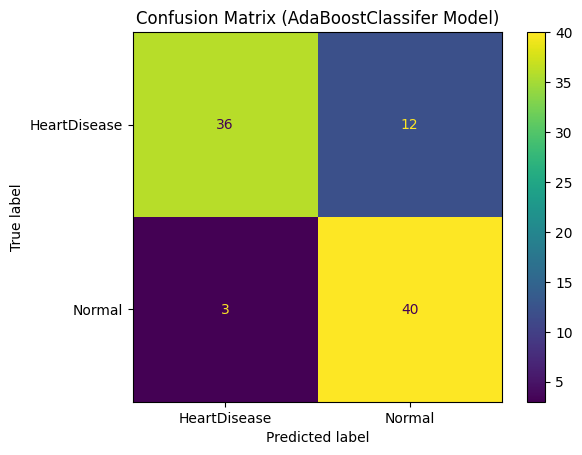

In [301]:
confuison_matrix = confusion_matrix(y_true=y_test, y_pred=pred_ada)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confuison_matrix, display_labels=["HeartDisease", "Normal"])
cm_display.plot()
plt.title("Confusion Matrix (AdaBoostClassifer Model)");

#### Support Vector Classifier

In [302]:
AccuracyScore = []
f1score =[]
RecallScore = []
PrecisionScore = []

params = {
    "C": 200,
    "kernel": "rbf",
    "gamma": "scale"
}
fold = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model_svc = SVC(**params)
    model_svc.fit(X_train,y_train)
    pred_svc = model_svc.predict(X_test)
    acc_score= accuracy_score(y_test, pred_svc)
    f1= f1_score(y_test, pred_svc)
    recall= recall_score(y_test, pred_svc)
    precision= precision_score(y_test, pred_svc)
    
AccuracyScore.append(acc_score)
f1score.append(f1)
RecallScore.append(recall)
PrecisionScore.append(precision)

print("Accuracy Score is: ", np.mean(AccuracyScore))
print("F1 Score is: ", np.mean(f1score))
print("Recall Score is: ", np.mean(RecallScore))
print("Precision Score is: ", np.mean(PrecisionScore))

Accuracy Score is:  0.8351648351648352
F1 Score is:  0.8421052631578948
Recall Score is:  0.9302325581395349
Precision Score is:  0.7692307692307693


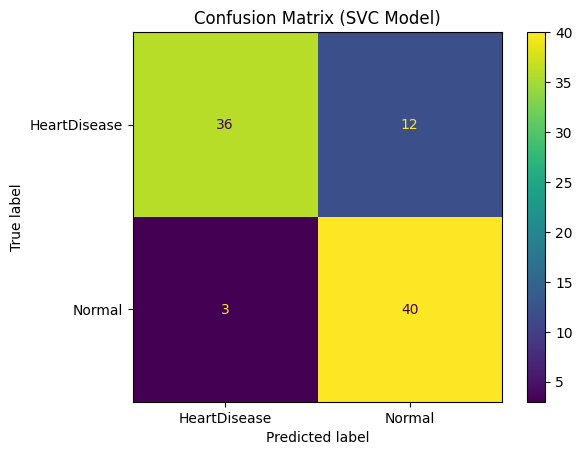

In [303]:
confuison_matrix = confusion_matrix(y_true=y_test, y_pred=pred_svc)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confuison_matrix, display_labels=["HeartDisease", "Normal"])
cm_display.plot()
plt.title("Confusion Matrix (SVC Model)");

#### GaussianNB    

In [304]:
AccuracyScore1 = []
f1score1 =[]
RecallScore1 = []
PrecisionScore1 = []

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kfold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model_gnb = GaussianNB()
    model_gnb.fit(X_train,y_train)
    pred_gnb = model_gnb.predict(X_test)
    acc_score1= accuracy_score(y_test, pred_gnb)
    f1_1= f1_score(y_test, pred_gnb)
    recall1= recall_score(y_test, pred_gnb)
    precision1= precision_score(y_test, pred_gnb)
    
AccuracyScore1.append(acc_score1)
f1score1.append(f1_1)
RecallScore1.append(recall1)
PrecisionScore1.append(precision1)

print("Accuracy Score is: ", np.mean(AccuracyScore1))
print("F1 Score is: ", np.mean(f1score1))
print("Recall Score is: ", np.mean(RecallScore1))
print("Precision Score is: ", np.mean(PrecisionScore1))

Accuracy Score is:  0.8021978021978022
F1 Score is:  0.8163265306122448
Recall Score is:  0.9302325581395349
Precision Score is:  0.7272727272727273


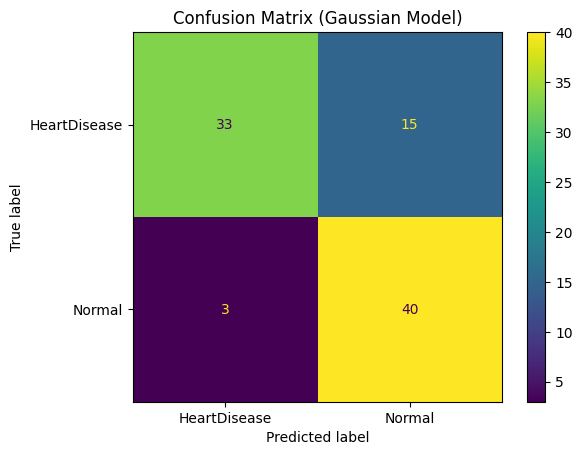

In [305]:
confuison_matrix = confusion_matrix(y_true=y_test, y_pred=pred_gnb)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confuison_matrix, display_labels=["HeartDisease", "Normal"])
cm_display.plot()
plt.title("Confusion Matrix (Gaussian Model)");

#### Ensembling Model       

In [306]:
#Instantiating the model
model1 = SVC(C=200, kernel="rbf", gamma="scale")
model2 = AdaBoostClassifier(n_estimators= 500, learning_rate= 0.1, random_state= 42)
model3 = GaussianNB()

stacking_model = StackingClassifier(estimators=[("svc", model1), ("ada_boost", model2), ("gaussian_nb", model3)])

cross_val_scores = cross_val_score(stacking_model, X_train, y_train, cv=10)

stacking_model.fit(X_train, y_train)
ensemble_pred = stacking_model.predict(X_test)
acc_score = accuracy_score(y_test, ensemble_pred)
f1 = f1_score(y_test, ensemble_pred)
class_report_ensemble = classification_report(y_test, ensemble_pred)
print(acc_score)
print(f1)
print(class_report_ensemble)

0.8131868131868132
0.8282828282828282
              precision    recall  f1-score   support

           0       0.94      0.69      0.80        48
           1       0.73      0.95      0.83        43

    accuracy                           0.81        91
   macro avg       0.84      0.82      0.81        91
weighted avg       0.84      0.81      0.81        91



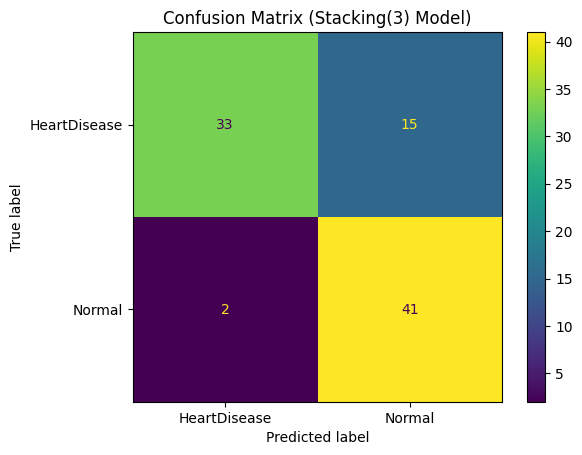

In [307]:
confuison_matrix = confusion_matrix(y_true=y_test, y_pred=ensemble_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confuison_matrix, display_labels=["HeartDisease", "Normal"])
cm_display.plot()
plt.title("Confusion Matrix (Stacking(3) Model)");

In [308]:
#Instantiating the model
model1 = SVC(C=200, kernel="rbf", gamma="scale")
model2 = AdaBoostClassifier(n_estimators= 500, learning_rate= 0.1, random_state= 42)
model3 = GaussianNB()

voting_model = VotingClassifier(estimators=[("svc", model1), ("ada_boost", model2), ("gaussian_nb", model3)])

cross_val_scores = cross_val_score(voting_model, X_train, y_train, cv=10)
voting_model.fit(X_train, y_train)
ensemble_pred1 = voting_model.predict(X_test)
acc_scores = accuracy_score(y_test, ensemble_pred1)
f1Scores = f1_score(y_test, ensemble_pred1)
class_report_ensemble1 = classification_report(y_test, ensemble_pred1)
print(acc_scores)
print(f1Scores)
print(class_report_ensemble1)

0.8241758241758241
0.8367346938775511
              precision    recall  f1-score   support

           0       0.94      0.71      0.81        48
           1       0.75      0.95      0.84        43

    accuracy                           0.82        91
   macro avg       0.84      0.83      0.82        91
weighted avg       0.85      0.82      0.82        91



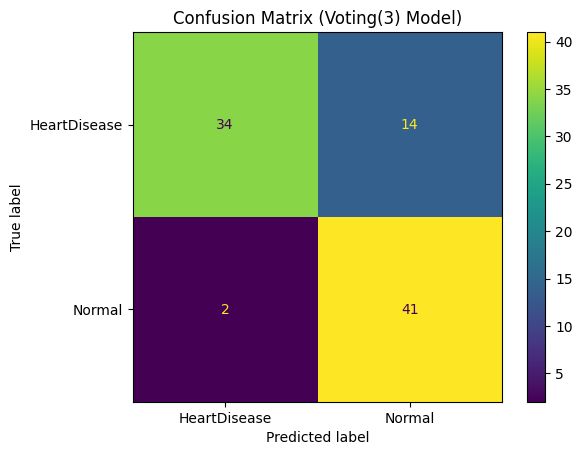

In [309]:
confuison_matrix = confusion_matrix(y_true=y_test, y_pred=ensemble_pred1)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confuison_matrix, display_labels=["HeartDisease", "Normal"])
cm_display.plot()
plt.title("Confusion Matrix (Voting(3) Model)");

In [310]:
model1 = SVC(C=200, kernel="rbf", gamma="scale")
model2 = AdaBoostClassifier(n_estimators= 500, learning_rate= 0.1, random_state= 42)

voting_models = VotingClassifier(estimators=[("svc", model1), ("ada_boost", model2)])

cross_val_scores = cross_val_score(voting_models, X_train, y_train, cv=10)
voting_models.fit(X_train, y_train)
ensemble_pred2 = voting_models.predict(X_test)
acc_scores = accuracy_score(y_test, ensemble_pred2)
f1Scores = f1_score(y_test, ensemble_pred2)
class_report_ensemble2 = classification_report(y_test, ensemble_pred2)
print(acc_scores)
print(f1Scores)
print(class_report_ensemble2)

0.8681318681318682
0.8666666666666666
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        48
           1       0.83      0.91      0.87        43

    accuracy                           0.87        91
   macro avg       0.87      0.87      0.87        91
weighted avg       0.87      0.87      0.87        91



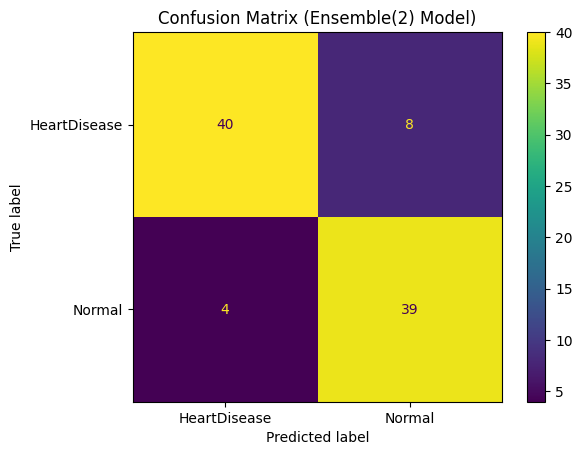

In [311]:
confuison_matrix = confusion_matrix(y_true=y_test, y_pred=ensemble_pred2)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confuison_matrix, display_labels=["HeartDisease", "Normal"])
cm_display.plot()
plt.title("Confusion Matrix (Ensemble(2) Model)");

In [312]:
model1 = SVC(C=200, kernel="rbf", gamma="scale")
model2 = AdaBoostClassifier(n_estimators= 500, learning_rate= 0.1, random_state= 42)

stacking_models = StackingClassifier(estimators=[("svc", model1), ("ada_boost", model2)])

cross_val_scores = cross_val_score(stacking_models, X_train, y_train, cv=10)
stacking_models.fit(X_train, y_train)
ensemble_pred3 = stacking_models.predict(X_test)
acc_scores = accuracy_score(y_test, ensemble_pred3)
f1Scores = f1_score(y_test, ensemble_pred3)
class_report_ensemble3 = classification_report(y_test, ensemble_pred3)
print(acc_scores)
print(f1Scores)
print(class_report_ensemble3)

0.7912087912087912
0.8080808080808081
              precision    recall  f1-score   support

           0       0.91      0.67      0.77        48
           1       0.71      0.93      0.81        43

    accuracy                           0.79        91
   macro avg       0.81      0.80      0.79        91
weighted avg       0.82      0.79      0.79        91



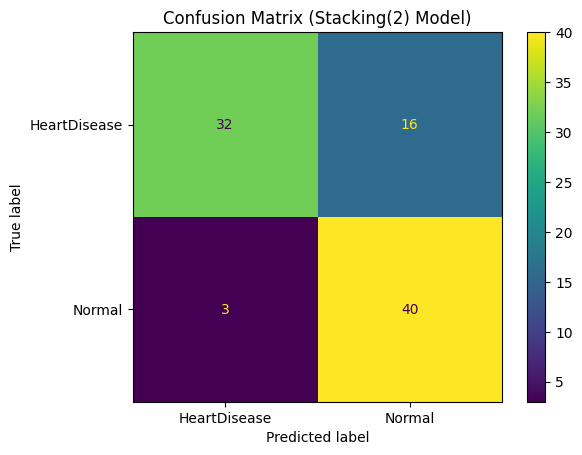

In [313]:
confuison_matrix = confusion_matrix(y_true=y_test, y_pred=ensemble_pred3)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confuison_matrix, display_labels=["HeartDisease", "Normal"])
cm_display.plot()
plt.title("Confusion Matrix (Stacking(2) Model)");

In [314]:
joblib.dump(voting_models, "ensemble_pred2.pkl")

['ensemble_pred2.pkl']